# IN-DEPTH ANALYSIS - KILLED OR SERIOUSLY INJURED DATA

## MACHINE LEARNING PROCESS

The KSI dataset consists mostly of categorical data, and hence we will use the method of supervised learning to make prediction on whether a certain person will survive or not from an accident. 
The independent variable in question is 'INJURY', which we will classify as Fatal/Major or Minimal as impact in a person from an accident

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import ipywidgets
import geocoder
import geopy
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

### 1. Preprocessing

 - Dropping unnecessary columns and engineer the date columns to get hour and day of the week

In [2]:
#import the data file for KSI - Killed or Seriously Injured from the Toronto Police Service webstie
data = pd.read_csv('ksidataupdated.csv', index_col = 0)
#dropping out some columns that are not of interest 
data = data.drop(columns = ['ACCNUM','LATITUDE', 'LONGITUDE', 'ObjectId', 'ADDRESS','TRSN_CITY_VEH', 'ACCLASS', 'Neighbourhood'])
#Replacing all other injury as Non-fatal 
data['INJURY']=data.INJURY.replace(['Minor', 'Minimal', 'Unknown/Other', 'None'], 'Minimal')
data['INJURY']=data.INJURY.replace(['Fatal', 'Major'], 'Fatal/Major')
#Creating a new column for day of the week
data.index = pd.to_datetime(data.index)
data['WEEKDAY'] = data.index.dayofweek
data.columns

Index(['HOUR', 'ROAD_CLASS', 'District', 'LOCCOORD', 'TRAFFCTL', 'VISIBILITY',
       'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
       'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE',
       'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN',
       'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'EMERG_VEH',
       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'Hood_ID', 'TRSN_CITY_', 'WEEKDAY'],
      dtype='object')

 - Checking for correlation between variables

The majority of our data includes categorical variables so we will perform Chi-square to determine independence.

In [3]:
# Split into feature variables and target variable
X = data.loc[:, data.columns != "INJURY"]
y = data["INJURY"]

print("The dataset contains {} rows and {} columns. \n".format(data.shape[0], data.shape[1]))
print("Number of unique values for each category: \n")
print(data.nunique().sort_values(ascending=False))

class_counts = data["INJURY"].value_counts()

print("Percentage of each class:")
print(class_counts/data.shape[0] * 100)
data.head()

The dataset contains 14457 rows and 38 columns. 

Number of unique values for each category: 

Hood_ID       140
VEHTYPE        27
HOUR           24
CYCLISTYPE     23
INVAGE         21
INVTYPE        17
PEDTYPE        16
MANOEUVER      15
PEDACT         15
DRIVACT        13
TRAFFCTL       12
IMPACTYPE      11
CYCACT         11
DRIVCOND        9
CYCCOND         9
PEDCOND         9
LIGHT           9
RDSFCOND        9
VISIBILITY      8
ROAD_CLASS      8
LOCCOORD        8
WEEKDAY         7
INITDIR         5
District        4
ALCOHOL         2
DISABILITY      2
EMERG_VEH       2
INJURY          2
REDLIGHT        2
TRUCK           2
SPEEDING        2
TRSN_CITY_      2
PASSENGER       2
PEDESTRIAN      2
CYCLIST         2
AUTOMOBILE      2
MOTORCYCLE      2
AG_DRIV         2
dtype: int64
Percentage of each class:
Minimal        57.418552
Fatal/Major    42.581448
Name: INJURY, dtype: float64


,HOUR,ROAD_CLASS,District,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,INVTYPE,...,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,TRSN_CITY_,WEEKDAY
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Driver,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6


Our dataset looks quite balanced in terms of the two classes: Minimal and Fatal/Major with slightly more number of people falling into the Minimal Injury (57.4% versus 42.6%)

#### Testing for variable independence (Chi-square test)

In order to determine independence of the feature variables and the target variables ('INJURY'), I will perform Chi-square test on each pair of one feature variable and the target variable.
<p>Our hypothesis for independence testing is as follows:</p>
<p>H0:  A and B are independent

H1: A and B are dependent</p>

In [4]:
# Define alpha
alpha = 0.05


chi2_check = []
for col in X.columns.values:
    a, b = data[col], data["INJURY"]

    pairobserved = pd.crosstab(a, b) 
    chi2, p, dof, expected = chi2_contingency(pairobserved.values)
    if p < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [X.columns.values, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

        Column                      Hypothesis
0         HOUR  Fail to Reject Null Hypothesis
1   ROAD_CLASS          Reject Null Hypothesis
2     District  Fail to Reject Null Hypothesis
3     LOCCOORD  Fail to Reject Null Hypothesis
4     TRAFFCTL  Fail to Reject Null Hypothesis
5   VISIBILITY  Fail to Reject Null Hypothesis
6        LIGHT  Fail to Reject Null Hypothesis
7     RDSFCOND  Fail to Reject Null Hypothesis
8    IMPACTYPE          Reject Null Hypothesis
9      INVTYPE          Reject Null Hypothesis
10      INVAGE          Reject Null Hypothesis
11     INITDIR          Reject Null Hypothesis
12     VEHTYPE          Reject Null Hypothesis
13   MANOEUVER          Reject Null Hypothesis
14     DRIVACT          Reject Null Hypothesis
15    DRIVCOND          Reject Null Hypothesis
16     PEDTYPE          Reject Null Hypothesis
17      PEDACT          Reject Null Hypothesis
18     PEDCOND          Reject Null Hypothesis
19  CYCLISTYPE          Reject Null Hypothesis
20      CYCAC

From the above we can see the following variables: HOUR, District, LOCCOORD, TRAFFCTL, VISIBILITY, LIGHT, RDSFCOND, EMERG_VEH, SPEEDING, ALCOHOL, DISABILITY, Hood_ID, TRSN_CITY_, WEEKDAY show high P-value corresponding to a higher dependency to the target variable 'INJURY'. 

#### Testing for correlations between feature variables

Another way to determine relationship between data is by looking at the Cramer's V. Chi-square test can be sensitive to sample size (here our sample size is big) and Cramer's V actually takes in consideration of the sample size. Cramer's V is a measure of association between features variables. The value is between 0 and 1, with a number closer to 1 denoting a strong association. We will have a look at the correlation between feature variables.

<b>Cramer's V formula</b>

$V=\sqrt{\frac{(\chi^2/n)}{min(c-1, r-1)}}$

where r corresponds to the number of rows, and c corresponds to the number of columns

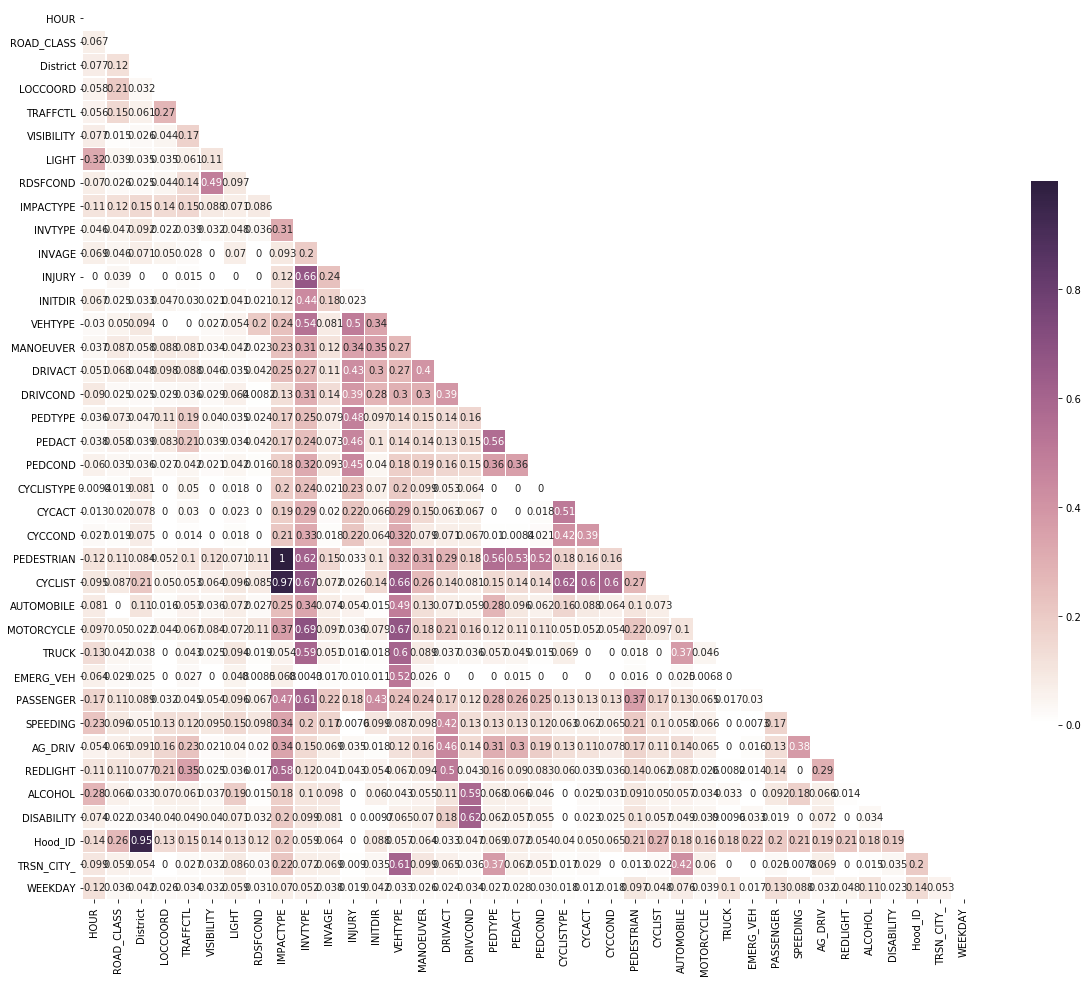

In [5]:
import itertools

def cramers_corrected_stat(confusion_matrix): 
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cols = list(data.columns.values)
corrM = np.zeros((len(cols),len(cols)))

# Calculate correlations of every combination of variables
for col1, col2 in itertools.combinations(cols, 2):

    A, B = data[col1], data[col2]
    
    idx1, idx2 = cols.index(col1), cols.index(col2)
    dfObserved = pd.crosstab(A,B) 
    corrM[idx1, idx2] = cramers_corrected_stat(dfObserved.values)
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

There is strong correlation between Hood_ID and District as different neighbourhoods are located in certain District. We will drop  District and keep Hood_ID

In [6]:
data.drop(columns = ['District'], inplace=True)

 -  Looking at variable INVTYPE and other highly correlated feature variables

In [7]:
data.INVTYPE.unique()

array(['Passenger', 'Driver', 'Other Property Owner', 'Pedestrian',
       'Motorcycle Driver', 'Cyclist', 'Truck Driver', 'Unknown/Other',
       'In-Line Skater', 'Driver - Not Hit', 'Motorcycle Passenger',
       'Moped Driver', 'Wheelchair', 'Pedestrian - Not Hit',
       'Trailer Owner', 'Witness', 'Cyclist Passenger'], dtype=object)

We notice that dummy variables 'PEDESTRIAN', 'CYCLIST', 'PASSENGER', 'TRUCK' also show up in INVTYPE and  that explains the high correlation. We can drop these variables because later one when we do OneHotEncoding, we will have duplicate variables representing the same thing.

In [8]:
data.drop(columns=['PEDESTRIAN', 'CYCLIST', 'PASSENGER', 'TRUCK'], inplace=True)

 -  Looking at the different categories for VEHTYPE and other highly correlated features

In [9]:
data.VEHTYPE.unique()

array(['Unknown/Other', 'Automobile, Station Wagon', 'Passenger Van',
       'Municipal Transit Bus (TTC)', 'Taxi', 'Motorcycle', 'Bicycle',
       'Truck - Open', 'Delivery Van', 'Moped', 'Police Vehicle',
       'Pick Up Truck', 'Truck-Tractor', 'Street Car',
       'Truck - Closed (Blazer, etc)', 'Bus (Other) (Go Bus, Gray Coach)',
       'Intercity Bus', 'Construction Equipment', 'Truck - Dump',
       'Off Road - 2 Wheels', 'Truck (other)', 'Truck - Tank',
       'Fire Vehicle', 'School Bus', 'Tow Truck',
       'Other Emergency Vehicle', 'Truck - Car Carrier'], dtype=object)

We also notice here that dummy variables 'AUTOMOBILE', 'MOTORCYCLE', 'EMERG_VEH', 'TRSN_CITY' also show up in VEHTYPE and  that explains the high correlation. We can drop these variables because later one when we do OneHotEncoding, we might potentially have duplicate variables.

In [67]:
data.drop(columns=['AUTOMOBILE', 'MOTORCYCLE', 'EMERG_VEH', 'TRSN_CITY_'], inplace=True)
# Update X and y
X = data.loc[:, data.columns != "INJURY"]
y = data["INJURY"]

KeyError: "['AUTOMOBILE' 'MOTORCYCLE' 'EMERG_VEH' 'TRSN_CITY_'] not found in axis"

#### - Converting data into numerical values

Machine learning requires that the input and the output variables being numerical values. As a result, the first step in getting the data ready is by making sure all the variables are in numerical form.
<p>For the X value, we will use the method called OneHotEncoder to transform the data into different columns since all the data we have are unordered categorical variables, we do not want our model to run as if the numbered ordering matters. OneHotEncoder will split data in the number of columns corresponding to the number of options for each categorical data.</p>

In [64]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
# Transform all the X's categorical values into numerical values

onehotencoder = OneHotEncoder()
X_coded = onehotencoder.fit_transform(X)
X_number=X_coded.toarray()
# y= column 'INJURY' is of binary value and hence we will convert it into binary label
lb = LabelBinarizer()
y_number = lb.fit_transform(y)

onehotencoder.get_feature_names()

array(['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7',
       'x0_8', 'x0_9', 'x0_10', 'x0_11', 'x0_12', 'x0_13', 'x0_14',
       'x0_15', 'x0_16', 'x0_17', 'x0_18', 'x0_19', 'x0_20', 'x0_21',
       'x0_22', 'x0_23', 'x1_Collector', 'x1_Expressway', 'x1_Laneway',
       'x1_Local', 'x1_Major Arterial', 'x1_Major Arterial Ramp',
       'x1_Minor Arterial', 'x1_Unknown/Other',
       'x2_Entrance Ramp Westbound', 'x2_Exit Ramp Southbound',
       'x2_Exit Ramp Westbound', 'x2_Intersection', 'x2_Mid-Block',
       'x2_Mid-Block (Abnormal)',
       'x2_Park, Private Property, Public Lane', 'x2_Unknown/Other',
       'x3_No Control', 'x3_PXO - No Ped', 'x3_Pedestrian Crossover',
       'x3_Police Control', 'x3_School Guard', 'x3_Stop Sign',
       'x3_Streetcar (Stop for)', 'x3_Traffic Controller',
       'x3_Traffic Gate', 'x3_Traffic Signal', 'x3_Unknown/Other',
       'x3_Yield Sign', 'x4_Clear', 'x4_Drifting Snow',
       'x4_Fog, Mist, Smoke, Dust', 'x4_Freezing Rain',

### 2. Building machine learning model

### Decision Tree Classifier

Now that we have our data ready, we will build a model to predict whether a person will suffer from a major/fatal injury or a minimal injury impact by running our data above. 
<p>The classification problem is a binary problem and hence we will be performing DecisionTreeClassifier.</p>

<b>Using KFold</b>

In [12]:
from sklearn.model_selection import cross_validate, KFold, ShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Define our data splitting
split = KFold(n_splits=5, shuffle=True, random_state=0)
treemodel = DecisionTreeClassifier(max_depth=15)
treemodel.fit(X_number, y_number.ravel())
scores = cross_validate(treemodel, X_number, y_number.ravel(), cv=split)
print("Test score:                  {}".format(scores["test_score"]))
# Print average across K tests
print("Average test score:       any   {} (+/- {})".format(scores["test_score"].mean(), scores["test_score"].std() * 2))

Test score:                  [0.8302213  0.82918396 0.8395019  0.8398478  0.8395019 ]
Average test score:       any   0.8356513728636543 (+/- 0.009739665729703023)


<b>Using train_test_split<b>

In [13]:
#Splitting the data into Training and Test data
X_train, X_test, y_train, y_test = train_test_split(X_number, y_number.ravel(), test_size = 0.30, random_state = 101)
tree2 = DecisionTreeClassifier(max_depth=15, criterion = 'gini')
tree2.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, accuracy_score
tree_predictions = tree2.predict(X_test)
print(accuracy_score(y_test, tree_predictions))

0.8335638543107423


<b>Changing the criterion to entropy (the default setting is 'gini')</b>

In [14]:
tree3 = DecisionTreeClassifier(max_depth=15, criterion = 'entropy')
tree3.fit(X_train, y_train)
tree3_predictions = tree3.predict(X_test)
print(accuracy_score(y_test, tree3_predictions))

0.8365606270170586


 -  Both KFold and train_test_split are giving us a similar accuracy rate (both around 83.5%). For a big dataset like this, it might be more computational appropriate to go with train_test_split.
 - The criterion = 'gini' performs slightly better than the criterion = 'entropy'

<b>Visualizing the trees with different max_depth to see the optimal values</b>

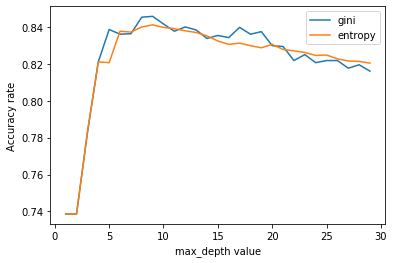

In [15]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_gini.append(accuracy_score(y_test, pred))
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_entropy.append(accuracy_score(y_test, pred))
 max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing the accuracy score for different max_depth values
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth value')
plt.ylabel('Accuracy rate')
plt.legend()

The graph above shows that max_depth value of around 9 or 10 gives us the best accuracy rate for 'gini' Decision Tree Classifier. Let's have our final trees as followed:

In [16]:
#Splitting the data into Training and Test data
finaltree = DecisionTreeClassifier(max_depth=10, criterion = 'gini')
finaltree.fit(X_train, y_train)
finaltree_predictions = finaltree.predict(X_test)
print(accuracy_score(y_test, finaltree_predictions))

0.8416320885200553


<b>Tuning the model</b>

In [17]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
std_slc = StandardScaler()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('decision tree', DecisionTreeClassifier(max_depth=10))])
final_scaled = pipe.fit(X_train, y_train)
final_scaled_pred = final_scaled.predict(X_test)
print(accuracy_score(y_test, final_scaled_pred))

0.8418626094974643


Tuning the tree model using pipeline slightly improve the model's accuracy

In [18]:
#using the inverse_transform function to determine how y is labeled as
lb.inverse_transform(np.array([0, 1]))

array(['Fatal/Major', 'Minimal'], dtype='<U11')

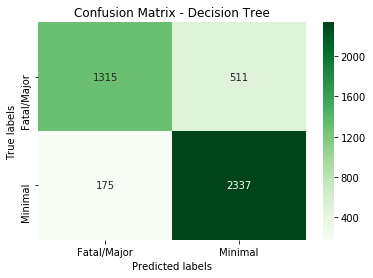

In [19]:
cm = confusion_matrix(y_test, final_scaled_pred)
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Decision Tree'); 
ax.xaxis.set_ticklabels(['Fatal/Major', 'Minimal']); ax.yaxis.set_ticklabels(['Fatal/Major', 'Minimal']);

In [20]:
print(classification_report(y_test,final_scaled_pred))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1826
           1       0.82      0.93      0.87      2512

    accuracy                           0.84      4338
   macro avg       0.85      0.83      0.83      4338
weighted avg       0.85      0.84      0.84      4338



The decision tree modelling gave us a pretty good result of 88% precision for prediction of Fatal/Major impact and 82% accuracy of predicting a person suffering from Minimal impact due to an accident. <p>The confusion matrix above also show us a better prediction of Minimal impact of (2340 times accurate and 508 inaccurate prediction) while with Fatal/Major impact the model is accurate 1318 times and the number of inaccurate prediction is low at 172 times.</p>

### Logistic Regression

In [21]:
#Creating the prediction model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='lbfgs')
log_model.fit(X_train, y_train)
#Performance Check
predictions = log_model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8497003227293684


/Users/sieusaominhngoc/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


<b>Searching for best performing hyperparameters for the models</b>

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
log_reg = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_list = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,C=c_list)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.843331 using {'C': 0.1, 'solver': 'liblinear'}
0.841256 (0.009537) with: {'C': 100, 'solver': 'newton-cg'}
0.841025 (0.009995) with: {'C': 100, 'solver': 'lbfgs'}
0.841256 (0.009537) with: {'C': 100, 'solver': 'liblinear'}
0.842376 (0.010090) with: {'C': 10, 'solver': 'newton-cg'}
0.842145 (0.010011) with: {'C': 10, 'solver': 'lbfgs'}
0.842376 (0.010103) with: {'C': 10, 'solver': 'liblinear'}
0.843067 (0.010044) with: {'C': 1.0, 'solver': 'newton-cg'}
0.843100 (0.010095) with: {'C': 1.0, 'solver': 'lbfgs'}
0.843067 (0.010092) with: {'C': 1.0, 'solver': 'liblinear'}
0.843298 (0.009397) with: {'C': 0.1, 'solver': 'newton-cg'}
0.843232 (0.009365) with: {'C': 0.1, 'solver': 'lbfgs'}
0.843331 (0.009623) with: {'C': 0.1, 'solver': 'liblinear'}
0.834700 (0.008576) with: {'C': 0.01, 'solver': 'newton-cg'}
0.834700 (0.008576) with: {'C': 0.01, 'solver': 'lbfgs'}
0.834799 (0.008522) with: {'C': 0.01, 'solver': 'liblinear'}


Based on the search above, we can see that the best performing logistic regression model is the one with C=0.1 and solver = 'liblinear'

<b>Running the best logistic regression model with C=0.1 and solver = 'liblinear'</b>

In [23]:
final_log = LogisticRegression(solver='liblinear', C=0.1)
final_log.fit(X_train, y_train)
log_predictions = final_log.predict(X_test)
print(accuracy_score(y_test, log_predictions))

0.8503918856615952


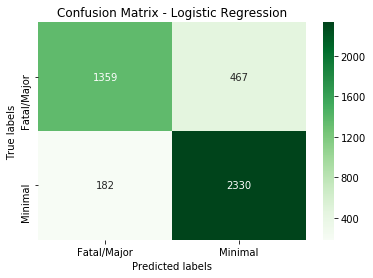

In [24]:
cm1 = confusion_matrix(y_test, log_predictions)   
ax= plt.subplot()
sns.heatmap(cm1, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Logistic Regression'); 
ax.xaxis.set_ticklabels(['Fatal/Major', 'Minimal']); ax.yaxis.set_ticklabels(['Fatal/Major', 'Minimal']);

Interestingly enough, by looking at the confusion matrix here for Logistic Regression and comparing it to the confusion matrix for Decision Tree, we can see that they both have similar true prediction for Fatal/Major accident but logistic regression is slightly better in predicting which person suffers from Minimal injury.

In [25]:
print(classification_report(y_test,log_predictions))

              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1826
           1       0.83      0.93      0.88      2512

    accuracy                           0.85      4338
   macro avg       0.86      0.84      0.84      4338
weighted avg       0.85      0.85      0.85      4338



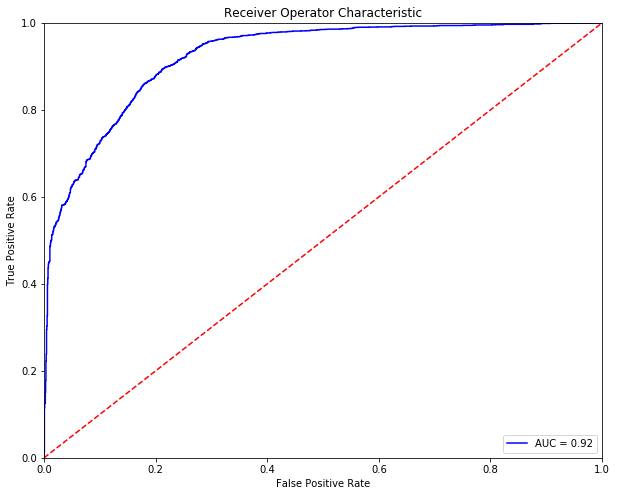

In [26]:
#Creating the ROC-AUC plot
preds = final_log.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC is very high here. Combined with the confusion matrix and classification report, logistic regression seems to be doing better than Decision Tree in modelling this situation.

### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier 

forest=RandomForestClassifier(n_estimators = 100, max_depth=15)
forest.fit(X_train, y_train)

# Predict and view stats
forest_prediction = forest.predict(X_test)
print(accuracy_score(y_test, forest_prediction))

0.8420931304748732


<b>Using GridSearch to find the best parameters for Random Forest</b>

In [28]:
r_forest = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
max_depth = [10,15,20]
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features, max_depth=max_depth)
grid_search = GridSearchCV(estimator=r_forest, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.840992 using {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 1000}
0.826663 (0.003991) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
0.828837 (0.001714) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.828046 (0.002354) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.803736 (0.014473) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
0.815298 (0.001913) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.815792 (0.001441) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}
0.834272 (0.001715) with: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 10}
0.835755 (0.001573) with: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
0.837138 (0.001624) with: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 1000}
0.821820 (0.003458) with: {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 10}
0.822809 (0.002443) with: 

Based on the Gridsearch above, the best combination for the parameter is max_depth= 20, max_features = sqrt and n_estimators =  1000.

<b>Running the best Random Forest Classifier</b>

In [51]:
final_forest=RandomForestClassifier(max_depth= 20, max_features = 'sqrt' ,n_estimators = 1000)
final_forest.fit(X_train, y_train)

# Predict and view stats
final_forest_pred = final_forest.predict(X_test)
print(accuracy_score(y_test, final_forest_pred))

0.8467035500230521


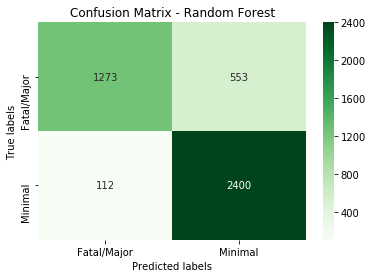

In [52]:
cm2 = confusion_matrix(y_test, final_forest_pred)   
ax= plt.subplot()
sns.heatmap(cm2, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Random Forest'); 
ax.xaxis.set_ticklabels(['Fatal/Major', 'Minimal']); ax.yaxis.set_ticklabels(['Fatal/Major', 'Minimal']);

Comparing with the other models, Random Forest Classifier seems to be doing better at prediction those suffering from Minimal impact but seems to make a lot of wrong prediction on those who might suffer from Fatal/Major accident.

In [53]:
print(classification_report(y_test,final_forest_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1826
           1       0.81      0.96      0.88      2512

    accuracy                           0.85      4338
   macro avg       0.87      0.83      0.84      4338
weighted avg       0.86      0.85      0.84      4338



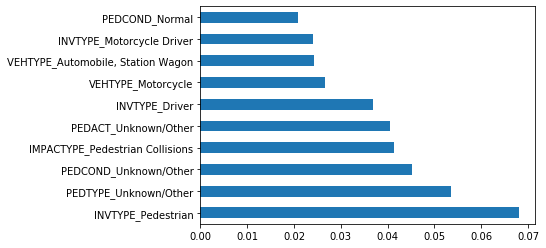

In [72]:
#Finding the most important features in the Random Forest model
feat_importances = pd.Series(final_forest.feature_importances_, index=onehotencoder.get_feature_names(input_features=X.columns))
feat_importances.nlargest(10).plot(kind='barh')

In [73]:
feat_importances.nlargest(10)

INVTYPE_Pedestrian                   0.068152
PEDTYPE_Unknown/Other                0.053646
PEDCOND_Unknown/Other                0.045191
IMPACTYPE_Pedestrian Collisions      0.041341
PEDACT_Unknown/Other                 0.040535
INVTYPE_Driver                       0.036879
VEHTYPE_Motorcycle                   0.026593
VEHTYPE_Automobile, Station Wagon    0.024188
INVTYPE_Motorcycle Driver            0.024163
PEDCOND_Normal                       0.020856
dtype: float64

Based on the above we can see that some features are more important in others in predicting the severity of an accident. The top 10 indicates that INVTYPE (involvement type, whether you are a pedestrian, driver or motorcycle driver), VEHTYPE (the type of vehicle) and PEDCOND (pedestrian conditions) are important features in the random forest model.

### Gradient Boosting Classifier

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gradient=GradientBoostingClassifier(random_state=0)
gradient.fit(X_train, y_train)

# Predict and view stats
gradient_prediction = gradient.predict(X_test)
print(accuracy_score(y_test, gradient_prediction))

0.8517750115260488


In [41]:
gradient_model = GradientBoostingClassifier(random_state=0)
n_estimators = [100, 1000]
learning_rate = [0.01, 0.1]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
grid_search = GridSearchCV(estimator= gradient_model, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.844945 using {'learning_rate': 0.01, 'n_estimators': 1000}
0.817472 (0.001569) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.844945 (0.000205) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.844649 (0.000649) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.835359 (0.003499) with: {'learning_rate': 0.1, 'n_estimators': 1000}


Based on the Gridsearch above, the best combination for the parameter is learning_rate=0.01 and n_estimators =  1000.

<b>Running the best Gradient Boosting Classifier</b>

In [33]:
final_gradient=GradientBoostingClassifier(random_state=0, learning_rate = 0.01, n_estimators=1000)
final_gradient.fit(X_train, y_train)

# Predict and view stats
final_grad_pred = final_gradient.predict(X_test)
print(accuracy_score(y_test, final_grad_pred))

0.851313969571231


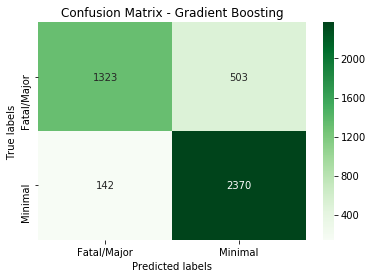

In [34]:
cm3 = confusion_matrix(y_test, final_grad_pred)   
ax= plt.subplot()
sns.heatmap(cm3, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Gradient Boosting'); 
ax.xaxis.set_ticklabels(['Fatal/Major', 'Minimal']); ax.yaxis.set_ticklabels(['Fatal/Major', 'Minimal']);

The matrix above shows us that Gradient Boosting seems to also be very good at predicting Minimal impact and the accuracy rate is as high if not slightly higher than logistic regression (at 85%).

In [35]:
print(classification_report(y_test,final_grad_pred))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1826
           1       0.82      0.94      0.88      2512

    accuracy                           0.85      4338
   macro avg       0.86      0.83      0.84      4338
weighted avg       0.86      0.85      0.85      4338



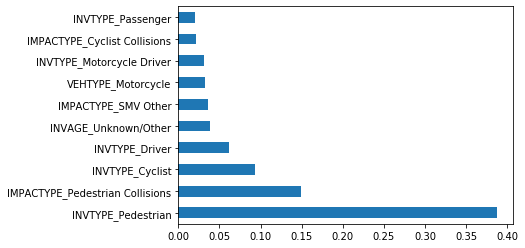

In [74]:
#Finding the most important features in the Random Forest model
feat_importances_gradient = pd.Series(final_gradient.feature_importances_, index=onehotencoder.get_feature_names(input_features=X.columns))
feat_importances_gradient.nlargest(10).plot(kind='barh')

In [75]:
feat_importances_gradient.nlargest(10)

INVTYPE_Pedestrian                 0.387980
IMPACTYPE_Pedestrian Collisions    0.149010
INVTYPE_Cyclist                    0.092721
INVTYPE_Driver                     0.061281
INVAGE_Unknown/Other               0.038476
IMPACTYPE_SMV Other                0.036454
VEHTYPE_Motorcycle                 0.032157
INVTYPE_Motorcycle Driver          0.031229
IMPACTYPE_Cyclist Collisions       0.021728
INVTYPE_Passenger                  0.020579
dtype: float64

Similarly to the random forest classification model, in gradient boosting, INVTYPE is important in predicting the outcome of an accident but IMPACTYPE is also considered one of the most important features.

### XGB Classifier

In [91]:
from xgboost import XGBClassifier
# fit model
xgbooster = XGBClassifier()
xgbooster.fit(X_train, y_train)
xgboost_prediction = xgboost.predict(X_test)
print(xgbooster)
print(accuracy_score(y_test, xgboost_prediction))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.8520055325034578


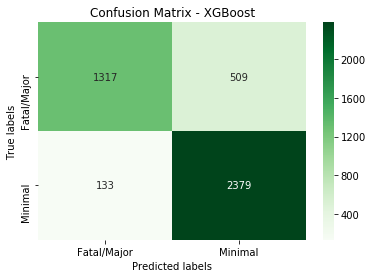

In [92]:
cm4 = confusion_matrix(y_test, xgboost_prediction)   
ax= plt.subplot()
sns.heatmap(cm4, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - XGBoost'); 
ax.xaxis.set_ticklabels(['Fatal/Major', 'Minimal']); ax.yaxis.set_ticklabels(['Fatal/Major', 'Minimal']);

In [93]:
print(classification_report(y_test,xgboost_prediction))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1826
           1       0.82      0.95      0.88      2512

    accuracy                           0.85      4338
   macro avg       0.87      0.83      0.84      4338
weighted avg       0.86      0.85      0.85      4338

